In [0]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnan, when, count
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator


In [0]:


# Create a SparkSession
spark = SparkSession.builder.appName("AirQualityPrediction").getOrCreate()

# Read the CSV file into a DataFrame
df = spark.read.csv("dbfs:/FileStore/shared_uploads/jjammula1@saintpeters.edu/city_day.csv", header=True, inferSchema=True)


In [0]:
df = df.withColumnRenamed("PM2.5", "PM25")
df.describe().to_pandas_on_spark().T

/databricks/spark/python/pyspark/sql/dataframe.py:5273: FutureWarning: DataFrame.to_pandas_on_spark is deprecated. Use DataFrame.pandas_api instead.
  warnings.warn(


,0,1,2,3,4
summary,count,mean,stddev,min,max
City,29531,None,None,Ahmedabad,Visakhapatnam
PM25,24933,67.45057794890272,64.66144945715128,0.04,949.99
PM10,18391,118.12710293078102,90.60510971779476,0.01,1000.0
NO,25949,17.574729662029284,22.785846333999626,0.02,390.68
NO2,25946,28.560659061126763,24.474745795589442,0.01,362.21
NOx,25346,32.309123333070055,31.646010936541806,0.0,467.63
NH3,19203,23.483476019371977,25.684274996166913,0.01,352.89
CO,27472,2.248598209085598,6.962884254189273,0.0,175.81
SO2,25677,14.531977255910002,18.133774845814642,0.01,193.86


In [0]:

# Define column mapping
column_mapping = {
    "PM2.5": "PM25",
    "PM10": "PM10",
    "NO": "Nitrogen_Oxide",
    "NO2": "Nitrogen_Dioxide",
    "NOx": "Nitrogen_Oxides",
    "NH3": "Ammonia",
    "CO": "Carbon_Monoxide",
    "SO2": "Sulfur_Dioxide",
    "O3": "Ozone",
    "Benzene": "Benzene",
    "Toluene": "Toluene",
    "Xylene": "Xylene",
    "AQI": "Air_Quality_Index",
    "AQI_Bucket": "AQI_Bucket"
}



In [0]:
# Rename columns
for old_col, new_col in column_mapping.items():
    df = df.withColumnRenamed(old_col, new_col)


In [0]:
# Select relevant columns for prediction
feature_columns = [
    "Nitrogen_Oxide", "Nitrogen_Dioxide", "Nitrogen_Oxides", "Ammonia", "Carbon_Monoxide",
    "Sulfur_Dioxide", "Ozone", "Benzene", "Toluene", "Xylene"
]
target_column = "Air_Quality_Index"

In [0]:
df.select([df[column] for column in feature_columns]).show()

+--------------+----------------+---------------+-------+---------------+--------------+------+-------+-------+------+
|Nitrogen_Oxide|Nitrogen_Dioxide|Nitrogen_Oxides|Ammonia|Carbon_Monoxide|Sulfur_Dioxide| Ozone|Benzene|Toluene|Xylene|
+--------------+----------------+---------------+-------+---------------+--------------+------+-------+-------+------+
|          0.92|           18.22|          17.15|   null|           0.92|         27.64|133.36|    0.0|   0.02|   0.0|
|          0.97|           15.69|          16.46|   null|           0.97|         24.55| 34.06|   3.68|    5.5|  3.77|
|          17.4|            19.3|           29.7|   null|           17.4|         29.07|  30.7|    6.8|   16.4|  2.25|
|           1.7|           18.48|          17.97|   null|            1.7|         18.59| 36.08|   4.43|  10.14|   1.0|
|          22.1|           21.42|          37.76|   null|           22.1|         39.33| 39.31|   7.01|  18.89|  2.78|
|         45.41|           38.48|           81.5

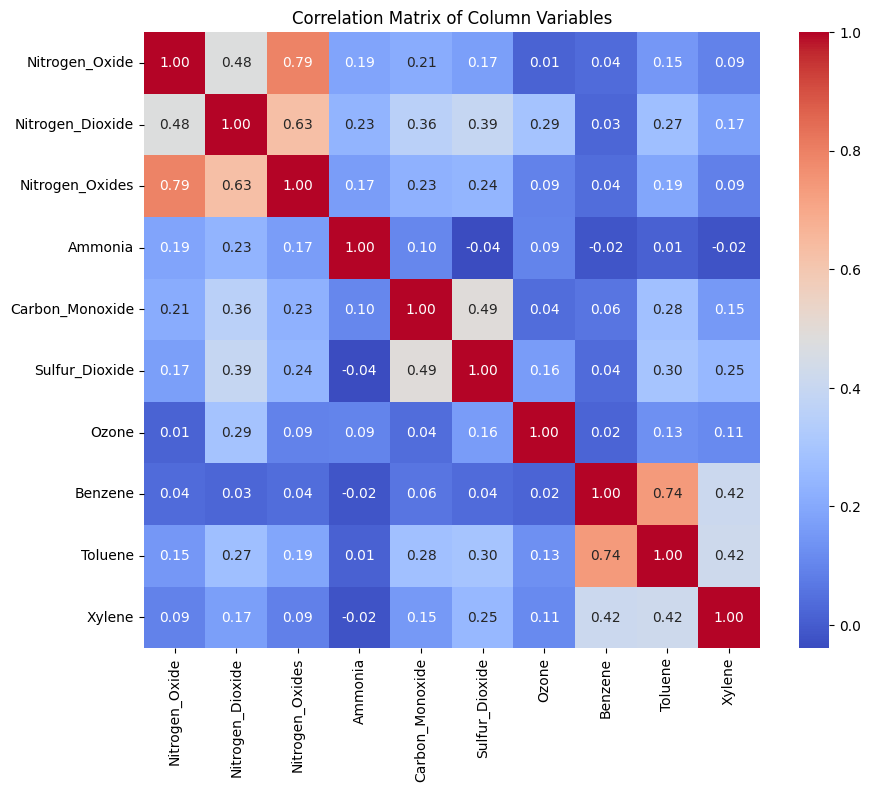

In [0]:
# Calculate the correlation matrix
correlation_matrix = df.select(feature_columns).toPandas().corr()

# Visualize the correlation matrix
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title('Correlation Matrix of Column Variables')
plt.show()


In [0]:
# Fill missing values with mean
mean_values = df.select([col(column).alias(column) for column in feature_columns])

# Check if mean values are not null
if mean_values.count() > 0:
    # Replace null mean values with default value (0)
    mean_values_dict = mean_values.first().asDict()
    mean_values_dict = {key: value if value is not None else 0 for key, value in mean_values_dict.items()}
    
    # Fill missing values in DataFrame with mean values
    filled_data = df.fillna(mean_values_dict)
else:
    print("Mean values are null, cannot fill missing values.")

In [0]:
# Select and assemble features
selected_data = filled_data.select(feature_columns + [target_column])
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
assembled_data = assembler.transform(selected_data)

In [0]:

# Split data into train and test sets
train_data, test_data = assembled_data.randomSplit([0.8, 0.2], seed=123)

# Drop rows with null or NaN values in the target column
data = train_data.dropna(subset=[target_column])

# Train RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="features", labelCol=target_column)
model = rf.fit(data)
datat = test_data.dropna(subset=[target_column])
predictions_var = model.transform(datat)


In [0]:
# Drop rows with null or NaN values in the target column
data = train_data.dropna(subset=[target_column])

# Train RandomForestRegressor model
rf = RandomForestRegressor(featuresCol="features", labelCol=target_column)
model = rf.fit(data)
datat = test_data.dropna(subset=[target_column])
predictions_var = model.transform(datat)

In [0]:
# Define hyperparameter grid
param_grid = ParamGridBuilder() \
    .addGrid(rf.numTrees, [10, 20, 30]) \
    .addGrid(rf.maxDepth, [5, 10, 15]) \
    .build()

In [0]:
# Create cross-validator
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
crossval = CrossValidator(estimator=rf, estimatorParamMaps=param_grid, evaluator=evaluator, numFolds=3)

In [0]:
from pyspark.sql.functions import isnan, col

# Filter rows with null or NaN values
cleaned_train_data = train_data.filter(~(isnan(col("Ozone")) | col("Ozone").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Xylene")) | col("Xylene").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Benzene")) | col("Benzene").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Toluene")) | col("Toluene").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Sulfur_Dioxide")) | col("Sulfur_Dioxide").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Carbon_Monoxide")) | col("Carbon_Monoxide").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Ammonia")) | col("Ammonia").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Nitrogen_Oxides")) | col("Nitrogen_Oxides").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Nitrogen_Dioxide")) | col("Nitrogen_Dioxide").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Nitrogen_Oxide")) | col("Nitrogen_Oxide").isNull()))
cleaned_train_data = cleaned_train_data.filter(~(isnan(col("Air_Quality_Index")) | col("Air_Quality_Index").isNull()))
# cleaned_train_data = cleaned_train_data.filter(~(isnan(col("features")) | col("features").isNull()))

# Train RandomForestRegressor model with hyperparameter tuning
model = crossval.fit(cleaned_train_data)



In [0]:
# Make predictions on the test data
predictions = model.transform(test_data)


In [0]:
predictions.show()

+--------------+----------------+---------------+-------+---------------+--------------+------+-------+-------+------+-----------------+--------------------+------------------+
|Nitrogen_Oxide|Nitrogen_Dioxide|Nitrogen_Oxides|Ammonia|Carbon_Monoxide|Sulfur_Dioxide| Ozone|Benzene|Toluene|Xylene|Air_Quality_Index|            features|        prediction|
+--------------+----------------+---------------+-------+---------------+--------------+------+-------+-------+------+-----------------+--------------------+------------------+
|          0.02|            0.02|           0.04|    0.0|           4.15|          0.86|133.36|    0.0|   0.02|   0.0|             null|[0.02,0.02,0.04,0...| 213.9159090909091|
|          0.02|            0.03|           0.04|    0.0|           3.07|          0.64|  0.02|    0.0|   0.02|   0.0|             null|[0.02,0.03,0.04,0...|200.51944444444447|
|          0.09|             7.0|            7.0|   0.02|           1.25|          3.62|133.36|   0.62|   1.61|  0.

In [0]:
from pyspark.sql.functions import col

# Check the schema of predictions
predictions.printSchema()

# Cast the columns to the expected data types
predictions = predictions.withColumn("prediction", col("prediction").cast("double"))
predictions = predictions.withColumn("Air_Quality_Index", col("Air_Quality_Index").cast("double"))



root
 |-- Nitrogen_Oxide: double (nullable = false)
 |-- Nitrogen_Dioxide: double (nullable = false)
 |-- Nitrogen_Oxides: double (nullable = false)
 |-- Ammonia: double (nullable = false)
 |-- Carbon_Monoxide: double (nullable = false)
 |-- Sulfur_Dioxide: double (nullable = false)
 |-- Ozone: double (nullable = false)
 |-- Benzene: double (nullable = false)
 |-- Toluene: double (nullable = false)
 |-- Xylene: double (nullable = false)
 |-- Air_Quality_Index: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- prediction: double (nullable = false)



In [0]:
evaluator = RegressionEvaluator(labelCol=target_column, predictionCol="prediction", metricName="rmse")
rmse = evaluator.evaluate(predictions_var)
print("Root Mean Squared Error (RMSE):", rmse)

Root Mean Squared Error (RMSE): 82.29571840334864


In [0]:
# Use the correct label column name
evaluator = RegressionEvaluator(labelCol="Air_Quality_Index", predictionCol="prediction", metricName="r2")

# Calculate the R-squared score
r2_score = evaluator.evaluate(predictions_var)
print("R2 score:", r2_score)

R2 score: 0.6549477070014464


In [0]:
predictions_var.select("features", target_column, "prediction").show()


+--------------------+-----------------+------------------+
|            features|Air_Quality_Index|        prediction|
+--------------------+-----------------+------------------+
|[0.09,7.0,7.0,0.0...|             86.0|131.49645047958415|
|[0.09,30.16,17.15...|             69.0| 138.2604861556104|
|[0.13,7.0,7.01,0....|             88.0|148.40617213377428|
|[0.21,61.69,61.91...|             83.0| 168.3091101365364|
|[0.25,16.71,9.02,...|            114.0| 106.0223047281286|
|[0.25,17.71,17.98...|             85.0|113.11677155631678|
|[0.26,30.14,17.15...|             84.0|137.13240542086865|
|[0.27,6.99,7.16,0...|            104.0|213.74946036235934|
|[0.29,0.95,0.36,0...|             14.0| 86.09118098761681|
|[0.32,28.86,29.19...|             61.0|136.52850764671146|
|[0.36,27.68,28.04...|            100.0|138.15754087601104|
|[0.4,26.85,14.05,...|             50.0| 87.96642451919604|
|[0.41,32.06,32.49...|             79.0|136.52850764671146|
|[0.48,20.93,21.42...|             78.0|

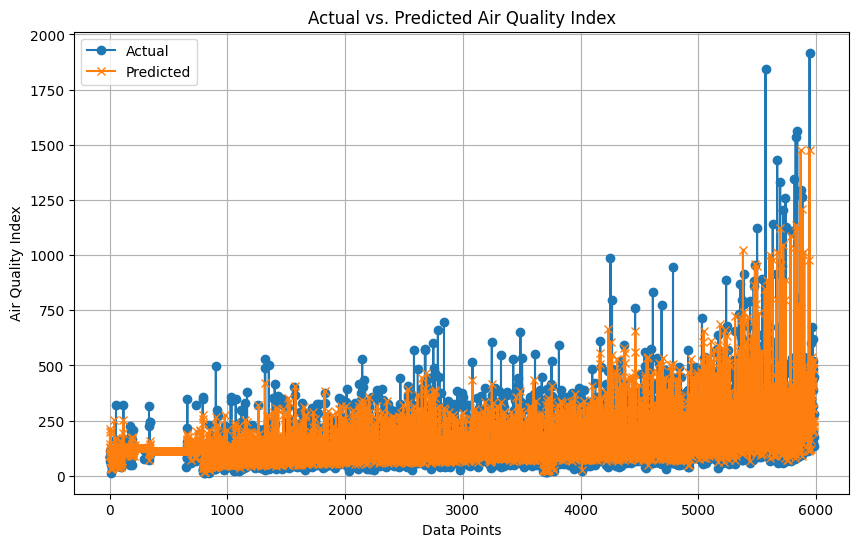

In [0]:
import matplotlib.pyplot as plt

# Extract actual and predicted values from the DataFrame
actual_values = predictions.select("Air_Quality_Index").collect()
predicted_values = predictions.select("prediction").collect()

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(actual_values, label='Actual', marker='o')
plt.plot(predicted_values, label='Predicted', marker='x')
plt.xlabel('Data Points')
plt.ylabel('Air Quality Index')
plt.title('Actual vs. Predicted Air Quality Index')
plt.legend()
plt.grid(True)
plt.show()
